In [15]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

# まとめ
- データを理解し，データを扱いやすい形に整形することは大事
- アルゴリズムの出した結果に対して，正しい評価を行うことが大事
    - 訓練データとテストデータを区別したり
- モデルとは，複雑な現実世界で起こる現象を理論的に単純化して近似したもの
    - モデルと実際のデータの誤差を小さくし，かつ未知のデータにも正しい答えを出力できるようにするのが目的
- 多項式フィッティングを使ってWebトラフィックの予測を行なった．
    - 次数を大きくしすぎると過学習を起こす
    - データの特徴から，フィッティング曲線を時間毎に分けてみることも一つの手

この本は，**機械学習**に興味があり，  
- 全体の設定は正しいのか？
- 最適な結果は得られているのか？
- より適したアルゴリズムが他にないことをどうやって判断すればいいのか？
- 集めたデータは「正しい」データだったのか？

といった疑問に応えるための本である．

機械学習のアプリケーションに割かれる時間  
1. データを読み込み，データを整形する
1. 入力データの調査および解釈を行う
1. 学習アルゴリズムにどのような形でデータを入力するのがふさわしいか分析を行う
1. 正しいモデルと学習アルゴリズムを選択する
1. 結果に対して正確な評価を行う

データの整形はアルゴリズムを複雑にするより大事

アルゴリズムを選択するときに考えるべきこと
- パフォーマンスのどこに重点をおくか？
- どのようなことが要求されているか？
- 正解率を犠牲にしても処理を高速に行うことを優先するか？
- 新しいデータを取得した場合，それを活用したいか，それともそれには保守的であるか

最後の評価の段階が一番間違いを犯しやすい．  
訓練データ，テストデータが偏っていないかを見分けるのは難しいことがある．  
機械学習の仕事の成否はデータにかかっている．  

この本は，機械学習の理論を詳しく説明した本ではなく，直感的な説明と実装を行なっている本である．  
入門者のためのスターターキットのような立ち位置である．

# はじめに
## Numpy SciPy Matplotlib入門
Numpyはだいたいわかるので省略

## SciPy入門
Numpyの配列を利用した数値計算ライブラリ
- 行列計算
- 線形代数
- 最適化問題
- クラスタリング
- 空間操作
- 高速フーリエ変換

Scipyのパッケージ
- **cluster: 階層クラスタリング(cluster.hierarchy), ベクトル量子化/Kmeans**
- constants: 物理数学定数
- fftpack: フーリエ変換
- integrate: 積分
- **interpolate: 補完(リニア，キュービックなど)**
- io: データの入出力
- linalg: BLASとLAPACKライブラリを用いた線形代数ルーチン
- maxentropy: エントロピー分布
- ndimage: n次元画像パッケージ
- odr: 直行距離回帰
- optimize: 最適化
- **signal: 信号処理**
- sparse: 疎行列
- spatial: 空間データ構造とアルゴリズム
- special: ベッセル関数，ヤコビアンなどの特殊関数
- **stats: 統計**

本書では太字になっているパッケージを主に利用する

# はじめての簡単な機械学習アプリケーション
現在のインフラがいつ限界に達するか？を考える．  
1時間に100000件のリクエストに対応できる．  
余分なサーバ費用をできるだけ発生させたくない．  

## データを読み込む
ch01/data/web_traffic.tsvにリクエストデータが収集されている．  

In [7]:
data = sp.genfromtxt("ch01/data/web_traffic.tsv", delimiter="\t") # scipyでデータ読み込みができる！
print(data[:10])
print(data.shape, "二次元データポイントが743個")

[[1.000e+00 2.272e+03]
 [2.000e+00 1.656e+03]
 [3.000e+00 1.386e+03]
 [4.000e+00 1.365e+03]
 [5.000e+00 1.488e+03]
 [6.000e+00 1.337e+03]
 [7.000e+00 1.883e+03]
 [8.000e+00 2.283e+03]
 [9.000e+00 1.335e+03]
 [1.000e+01 1.025e+03]]
(743, 2) 二次元データポイントが743個


## 前処理とデータ整形
時間軸とアクセス数の軸をそれぞれ別のベクトルとして扱う

In [8]:
x = data[:, 0]
y = data[:, 1]

yには不適切な値nanが含まれているので取り除く

In [10]:
sp.sum(sp.isnan(y)) # なぜかこのデータには含まれていない

0

In [11]:
# 不適切なデータを取り除く
x = x[~sp.isnan(y)]
y = y[~sp.isnan(y)]

ここまでで，これらx,yを使って散布図を書いてみる

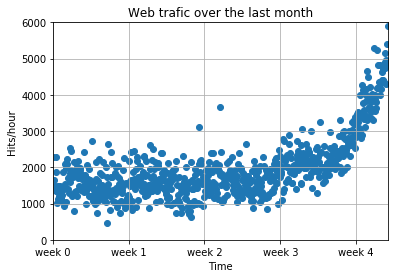

In [52]:
def show_graph(x, y):
    plt.scatter(x, y)
    plt.title("Web trafic over the last month")
    plt.xlabel("Time")
    plt.ylabel("Hits/hour")
    plt.xticks([w*7*24 for w in range(10)], ['week %i' % w for w in range(10)])
    plt.autoscale(tight=True)
    plt.ylim(0, 6000)
    plt.grid()
    plt.show()

show_graph(x, y)

## 正しいモデルの選択と機械学習
モデルとは，複雑な現実世界で起こる現象を理論的に単純化して近似したもの  
モデルと現実のデータの誤差を小さくしていくのが目的  
例えば二乗誤差  
<br>
直線でさっきのデータを近似してみる

In [27]:
sp.polyfit?

In [25]:
fp1, residuals, rank, singular_value, relative_condition_number = sp.polyfit(x, y, deg=1, full=True)
# fp1: 近似モデルのパラメータ
# residuals: 近似誤差
# deg: fitさせるモデルの次数を指定
# full: モデルパラメータだけでなく，fp1やsingular valueなども取得する

In [26]:
print("Model parameters: %s" % fp1)
print(residuals)

Model parameters: [   2.57152281 1002.10684085]
[3.19874315e+08]


poly1d（）を用いることで，モデルパラメータからモデル関数を作成

In [36]:
sp.poly1d?

In [28]:
f1 = sp.poly1d(fp1)

def error(f, x, y):
    return sp.sum((f(x) - y) ** 2)

print(error(f1, x, y))

319874314.7774192


このような誤差は，それ単体では良いか悪いか判別できず，他の手法と比較したときにその良し悪しがわかる．

In [32]:
plt.plot?

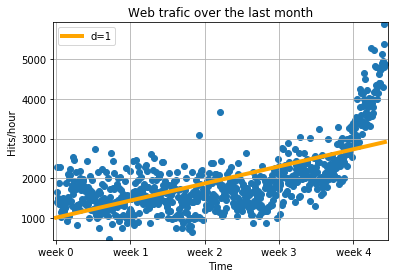

In [40]:
fx = sp.linspace(0, x[-1], 1000) # プロット用にx値を生成
plt.plot(fx, f1(fx), linewidth=4, color="orange") # 1次の近似線を描画
plt.legend(["d=%i" % f1.order], loc="upper left")

show_graph(x, y)

2次曲線ならどうか 

In [38]:
f2p = sp.polyfit(x, y, 2)
print(f2p)
f2 = sp.poly1d(f2p) # 1次式なのに2次式？
print(error(f2, x, y))

[ 1.04688184e-02 -5.21727812e+00  1.96921629e+03]
182006476.43171012


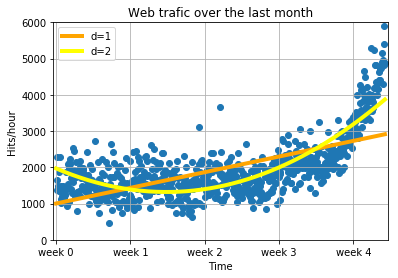

In [53]:
fx = sp.linspace(0, x[-1], 1000) # プロット用にx値を生成
plt.plot(fx, f1(fx), linewidth=4, color="orange") # 1次の近似線を描画
plt.plot(fx, f2(fx), linewidth=4, color="yellow") # 2次の近似線を描画

plt.legend(["d=%i" % f1.order, "d=%i" % f2.order], loc="upper left")

show_graph(x, y)

このようにして次数を上げていけばよりこのデータには合致するが，過学習の恐れがある．  
過学習によって，プロセスの本質を捉えているだけではなく，データに含まれるノイズにまでも適応してしまう．  
<br>
このようなとき取るべき行動は以下のようなものがある．  
- 多項式モデルからどれか一つを選択する
- より複雑なモデル(スプライン曲線など）に切り替える
- データについて別の視点で考え，初めからやり直す

ここでは，3つめの方法を実施するのが良さそう  
我々の扱っているデータは，3.5週目で急に変化しているように見える．  
そこで，1つめの直線を3．5週より前のデータを用いて学習し，2つめの直線はそれ以降のデータを使うことにする．  

136467834.76562506


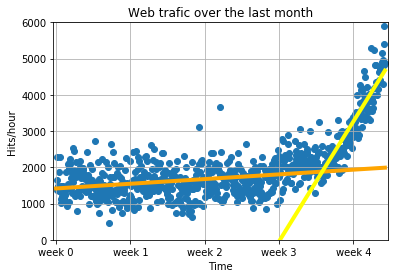

In [55]:
inflection = int(3.5 * 7 * 24) # 変化点の時刻(inflection: 曲がること)
xa = x[:inflection]
ya = y[:inflection]
xb = x[inflection:]
yb = y[inflection:]

fa = sp.poly1d(sp.polyfit(xa, ya, 1))
fb = sp.poly1d(sp.polyfit(xb, yb, 1))

fa_error = error(fa, xa, ya)
fb_error = error(fb, xb, yb)

print(fa_error + fb_error)

fx = sp.linspace(0, x[-1], 1000) # プロット用にx値を生成

plt.plot(fx, fa(fx), linewidth=4, color="orange") # 1次の近似線を描画
plt.plot(fx, fb(fx), linewidth=4, color="yellow") # 2次の近似線を描画

show_graph(x, y)

しかし依然として誤差は大きい．  
次数を上げれば誤差を小さくできるが，未来を予測できるかどうかはよくわからない  
<br>
そこで，データを訓練データとテストデータに分ける．  
このときテスト用としてデータから抜き出されたデータを**ホールドアウトデータ**と呼ぶ  

In [58]:
frac = 0.3 # テストに用いるデータの割合
split_idx = int(frac * len(xb))

# 全データの30%をランダムに選び出す
shuffled = sp.random.permutation(list(range(len(xb)))) # インデックスをシャッフル
test = sorted(shuffled[:split_idx]) # シャッフルしたデータからfracだけデータをサンプル
train = sorted(shuffled[split_idx:]) # 残りのデータ

# それぞれ訓練データを用いて訓練を行う
fbt1 = sp.poly1d(sp.polyfit(xb[train], yb[train], 1))
fbt2 = sp.poly1d(sp.polyfit(xb[train], yb[train], 2))
fbt3 = sp.poly1d(sp.polyfit(xb[train], yb[train], 3))
fbt10 = sp.poly1d(sp.polyfit(xb[train], yb[train], 10))
fbt100 = sp.poly1d(sp.polyfit(xb[train], yb[train], 100))

for f in [fbt1, fbt2, fbt3, fbt10, fbt100]:
    print("Error d = %i: %f" % (f.order, error(f, xb[test], yb[test])))


Error d = 1: 9098182.598223
Error d = 2: 7059304.791464
Error d = 3: 7125153.464033
Error d = 10: 8047000.141757
Error d = 53: 7862631.761643


/Users/komatsu/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:13: RankWarning: Polyfit may be poorly conditioned
  del sys.path[0]
/Users/komatsu/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:14: RankWarning: Polyfit may be poorly conditioned
  


この場合はd=3かd=2の結果がもっとも優れていた．

あとは，時間当たりのリクエストが100000を超える時期を予想する．

In [60]:
from scipy.optimize import fsolve
fsolve?

In [79]:
print(fbt2)
print(fbt2 - 100000)
print(fsolve(fbt2-100000, 800)) # find solve 到達するxは？(x=800にもっとも近い解を出力, 二次式なので解が二つ出る)

reached_max = fsolve(fbt2-100000, 800) / (7 * 24) # 何周目に到達？
print("100000 hits/hour expected at week %f" % reached_max[0])

         2
0.08889 x - 98.57 x + 2.919e+04
         2
0.08889 x - 98.57 x - 7.081e+04
[1605.26889705]
100000 hits/hour expected at week 9.555172
